In [40]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.interpolate import UnivariateSpline

from model import WeightedEnsembleGB

In [41]:
gen2_train = pd.read_csv('./data/gen2_train.csv')
gen2_test = pd.read_csv('./data/gen2_test.csv')
sample_sub = pd.read_csv('../data/gen2_test_solution_template.csv')
gen1_train = pd.read_csv('./data/gen1_train.csv')
gen1_test = pd.read_csv('./data/gen1_test.csv')

target_ages = [10, 11, 12, 13, 14, 15, 16, 18]  # Skip age 17

In [42]:
def plot_feature_importance(model, feature_names, model_name):
    if model_name == "Lasso":
        importance = np.abs(model.named_steps["model"].coef_)
    elif model_name == "RandomForest":
        importance = model.best_estimator_.named_steps["model"].feature_importances_
    elif model_name == "GradientBoosting":
        importance = model.best_estimator_.named_steps["model"].feature_importances_
    else:
        raise ValueError("Unsupported model type")
    
    feature_importance = pd.DataFrame({"Feature": feature_names, "Importance": importance})
    feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance["Feature"][:20], feature_importance["Importance"][:20], color="royalblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Top Features - {model_name}")
    plt.gca().invert_yaxis()
    plt.savefig(f"./viz/feature_importance_{model_name}", bbox_inches='tight')
    plt.show()

In [43]:
def prepare_modeling_data_v3(gen2_df, target_age, is_test_set=False):
    # early measurements (ages 0-9) for feature extraction
    early_data = gen2_df[gen2_df['AgeGr'] <= 9].copy()
    
    if early_data.empty:
        return pd.DataFrame(), pd.Series()
    
    features = []
    for _, group in early_data.groupby('gen2_id'):
        feature_dict = {
            'gen2_id': group['gen2_id'].iloc[0],
            'early_mean_height': group['SHgt_cm'].mean(),
            'early_max_height': group['SHgt_cm'].max(),
            'early_max_velocity': group['height_velocity'].max(),
            'early_mean_velocity': group['height_velocity'].mean(),
            'parent_adult_height': group['parent_adult_height'].iloc[0],
            'is_female': group['is_female'].iloc[0],
            'height_percentile_sex': group['height_percentile_sex'].mean(),
            'early_acceleration': group['height_acceleration'].mean(),
        }

        # growth momentum features
        last_measurements = group.sort_values('AgeGr').tail(3)
        if len(last_measurements) >= 3:
            feature_dict['recent_growth_rate'] = np.polyfit(
                last_measurements['AgeGr'],
                last_measurements['SHgt_cm'],
                1
            )[0]
        else:
            feature_dict['recent_growth_rate'] = np.nan

        # spline-based features
        if len(group) >= 5:  # need enough points for a decent spline fit
            try:
                # sorting by age
                group_sorted = group.sort_values('AgeGr')
                # fitting spline to height data
                height_spline = UnivariateSpline(
                    group_sorted['AgeGr'], 
                    group_sorted['SHgt_cm'], 
                    k=3,  # Cubic spline
                    s=0.5  # Smoothing factor
                )
                age_grid = np.linspace(group_sorted['AgeGr'].min(), group_sorted['AgeGr'].max(), 100)
                # calculate velocity (1st derivative)
                velocity_spline = height_spline.derivative(n=1)
                velocities = velocity_spline(age_grid)
                # calculate acceleration (2nd derivative)
                acceleration_spline = height_spline.derivative(n=2)
                accelerations = acceleration_spline(age_grid)
                
                # find inflection points (acceleration crosses zero)
                inflection_points = np.where(np.diff(np.signbit(accelerations)))[0]
                if len(inflection_points) > 0:
                    # add ages at inflection points as features
                    feature_dict['spline_inflection_age'] = age_grid[inflection_points[0]]
                else:
                    feature_dict['spline_inflection_age'] = np.nan
            except Exception as e:
                feature_dict['spline_inflection_age'] = np.nan
        else:
            feature_dict['spline_inflection_age'] = np.nan

        features.append(feature_dict)

    features_df = pd.DataFrame(features)
    
    if features_df.empty:
        return pd.DataFrame(), pd.Series()
    
    if is_test_set:
        X = features_df.drop(['gen2_id'], axis=1)
        y = pd.Series()  # Empty target for test set
        return X, y
    
    # merge training with target heights
    target_data = gen2_df[
        (gen2_df['AgeGr'] >= target_age - 0.1) &
        (gen2_df['AgeGr'] <= target_age + 0.1)
    ][['gen2_id', 'SHgt_cm']].copy()
    
    merged = features_df.merge(target_data, on='gen2_id', how='inner')
    
    X = merged.drop(['gen2_id', 'SHgt_cm'], axis=1)
    y = merged['SHgt_cm']
    
    return X, y

Training model for age 10...
Optimized weights: Lasso=0.499, RF=0.501, GB=0.000
Optimized weights: Lasso=0.676, RF=0.248, GB=0.076
Optimized weights: Lasso=1.000, RF=0.000, GB=0.000
Optimized weights: Lasso=0.867, RF=0.133, GB=0.000
Optimized weights: Lasso=0.734, RF=0.266, GB=0.000
Cross-Validation Mean RMSE: 1.2533
Tuning Lasso hyperparameters...
Best Lasso alpha: 0.11315831998707704
Tuning RandomForest hyperparameters...
Best RF params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Tuning GradientBoostingRegressor hyperparameters...
Best GB params: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validat

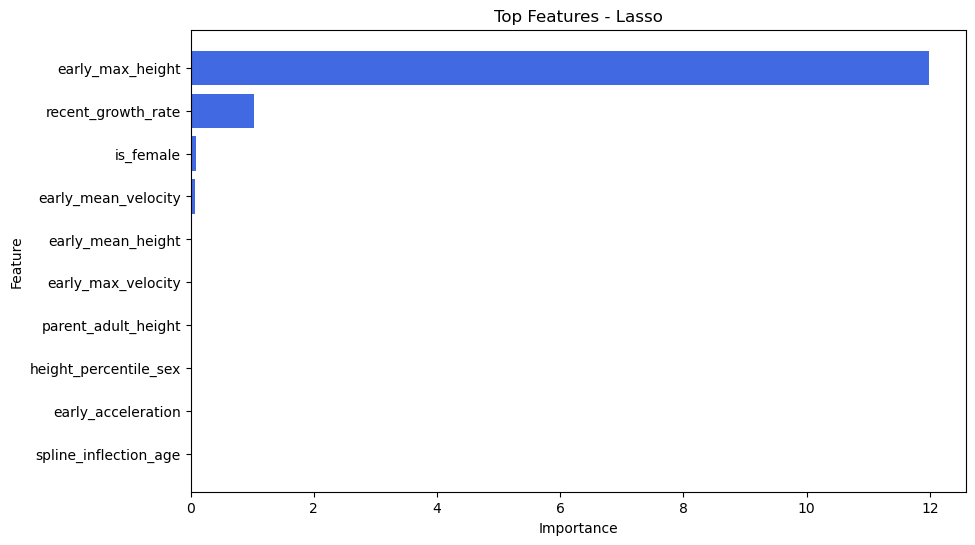

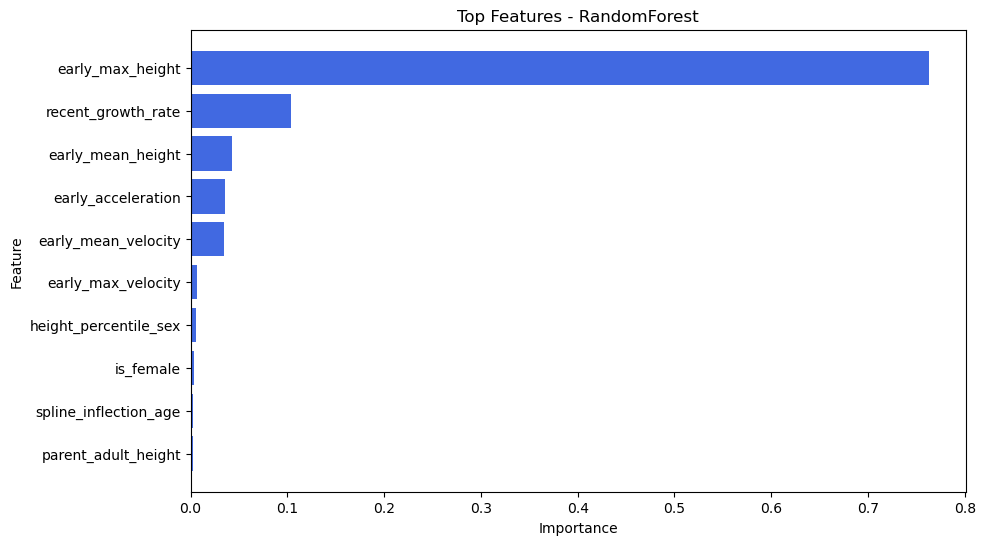

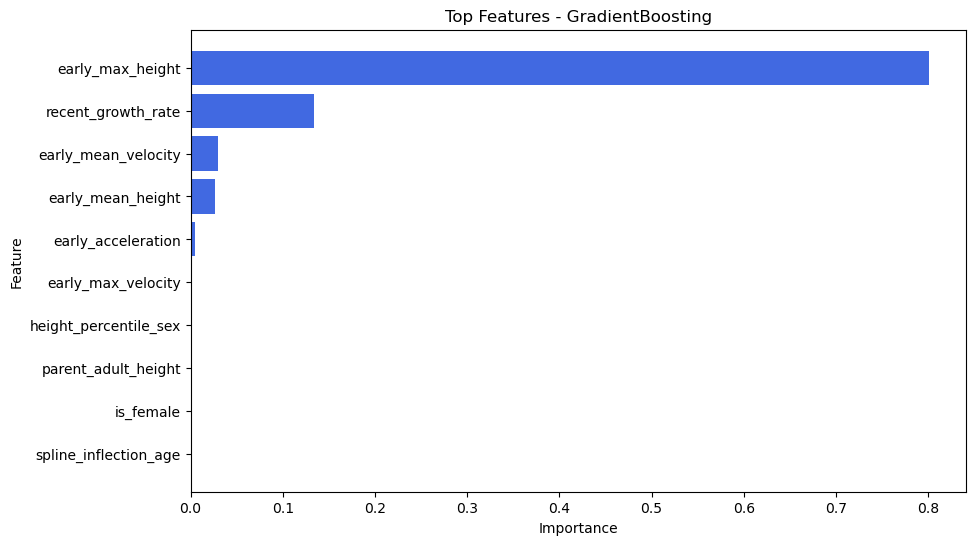

Training model for age 11...
Optimized weights: Lasso=0.545, RF=0.109, GB=0.346
Optimized weights: Lasso=0.821, RF=0.000, GB=0.179
Optimized weights: Lasso=1.000, RF=0.000, GB=0.000
Optimized weights: Lasso=0.839, RF=0.147, GB=0.014
Optimized weights: Lasso=0.649, RF=0.215, GB=0.136
Cross-Validation Mean RMSE: 2.2514
Tuning Lasso hyperparameters...
Best Lasso alpha: 0.09479615881004037
Tuning RandomForest hyperparameters...
Best RF params: {'model__max_depth': 15, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Tuning GradientBoostingRegressor hyperparameters...
Best GB params: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validatio

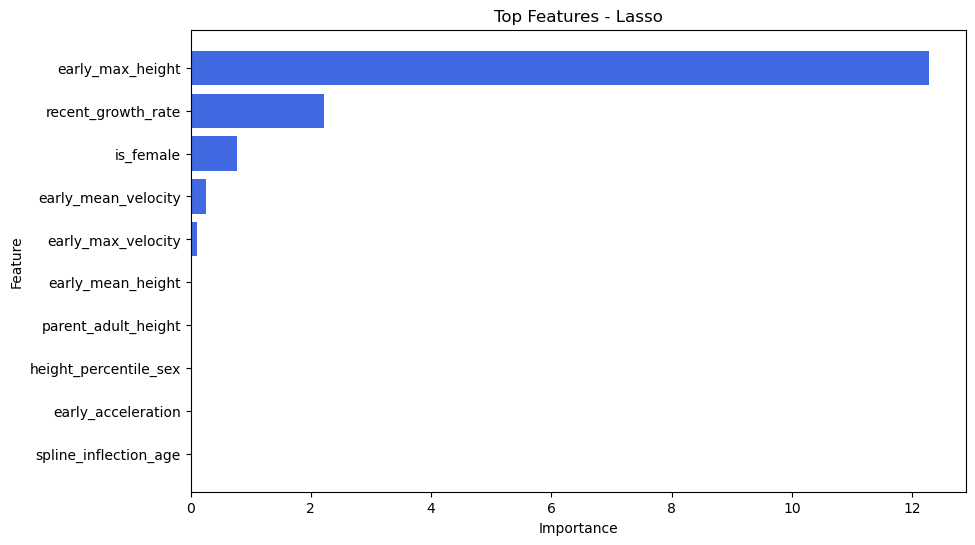

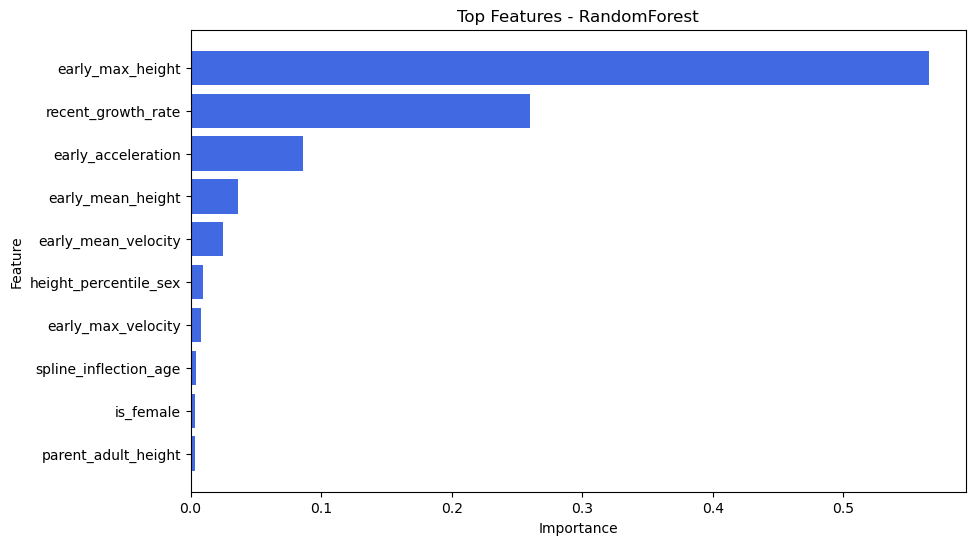

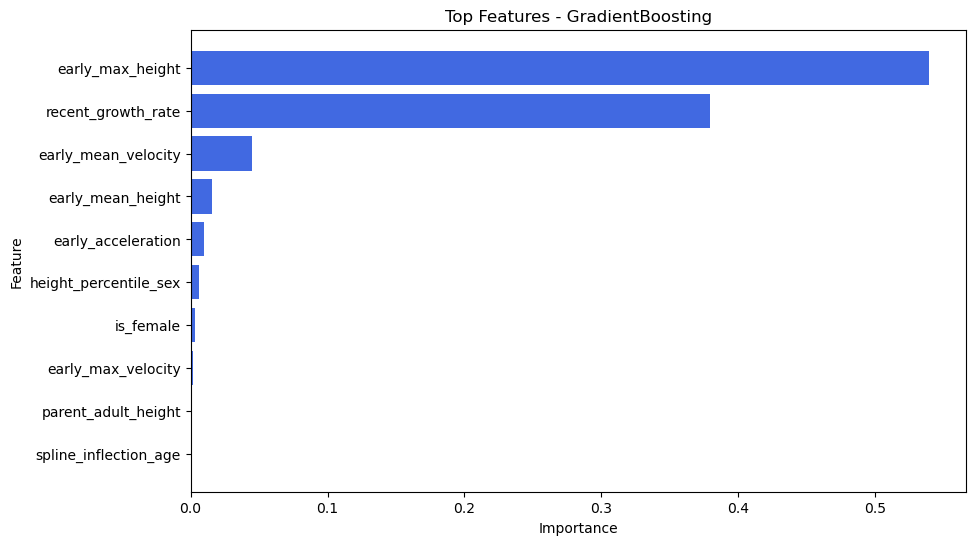

Training model for age 12...
Optimized weights: Lasso=0.484, RF=0.193, GB=0.323
Optimized weights: Lasso=0.518, RF=0.316, GB=0.166
Optimized weights: Lasso=1.000, RF=0.000, GB=0.000
Optimized weights: Lasso=0.723, RF=0.122, GB=0.155
Optimized weights: Lasso=0.763, RF=0.237, GB=0.000
Cross-Validation Mean RMSE: 3.2556
Tuning Lasso hyperparameters...
Best Lasso alpha: 0.10294555269836042
Tuning RandomForest hyperparameters...
Best RF params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Tuning GradientBoostingRegressor hyperparameters...
Best GB params: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validat

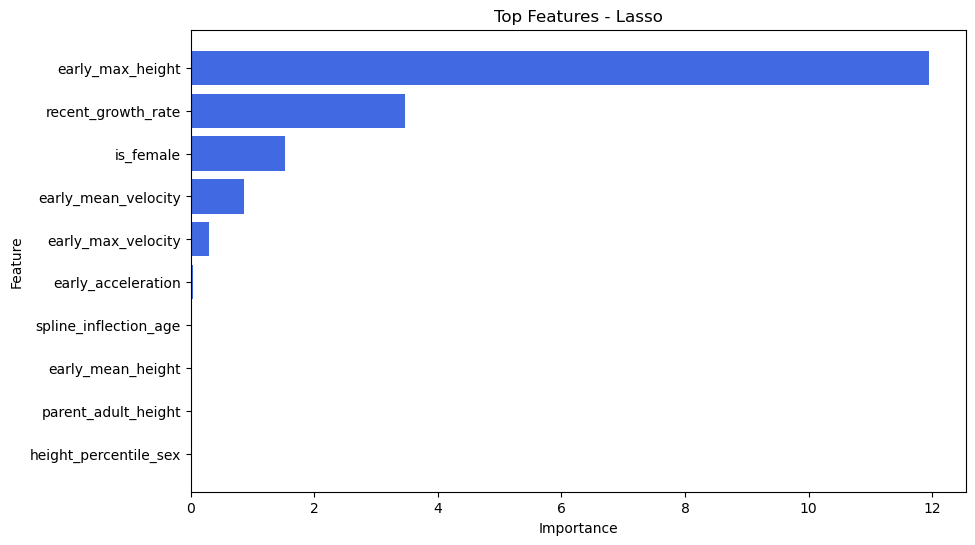

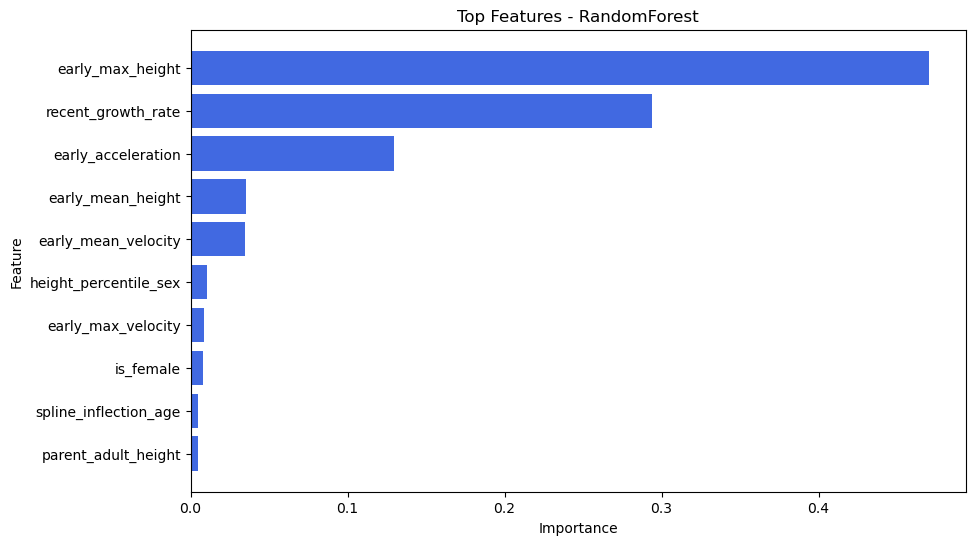

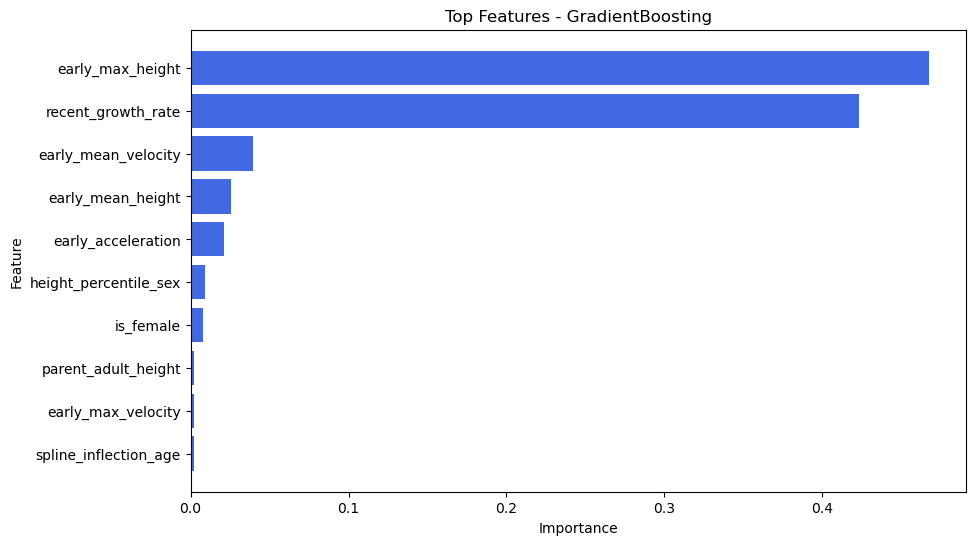

Training model for age 13...
Optimized weights: Lasso=0.317, RF=0.683, GB=0.000
Optimized weights: Lasso=0.147, RF=0.535, GB=0.318
Optimized weights: Lasso=1.000, RF=0.000, GB=0.000
Optimized weights: Lasso=0.612, RF=0.388, GB=0.000
Optimized weights: Lasso=0.908, RF=0.092, GB=0.000
Cross-Validation Mean RMSE: 4.5687
Tuning Lasso hyperparameters...
Best Lasso alpha: 0.1679798428584128
Tuning RandomForest hyperparameters...
Best RF params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Tuning GradientBoostingRegressor hyperparameters...
Best GB params: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validati

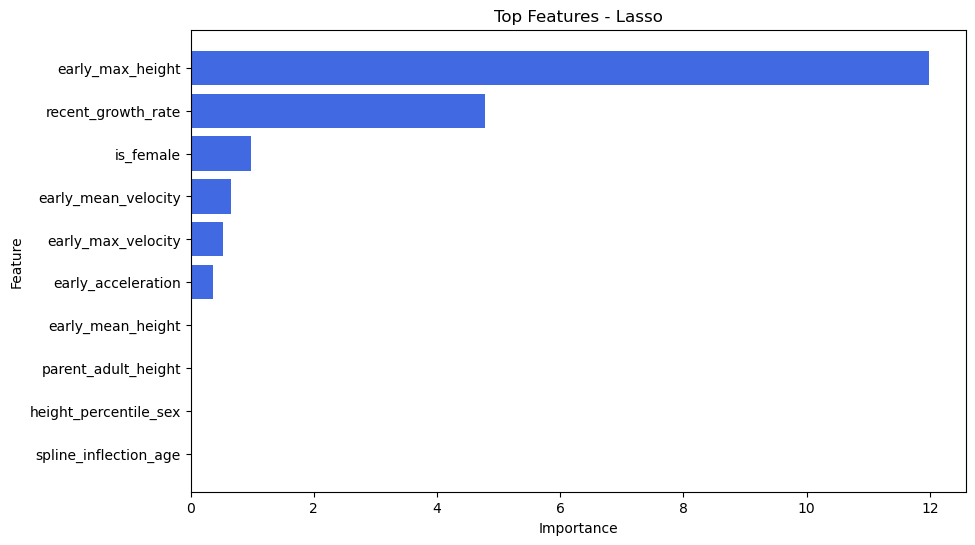

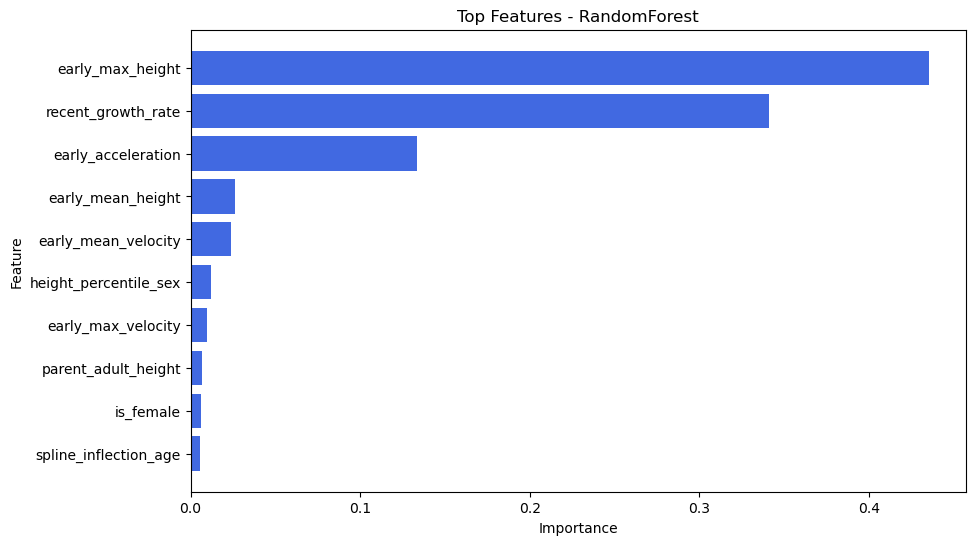

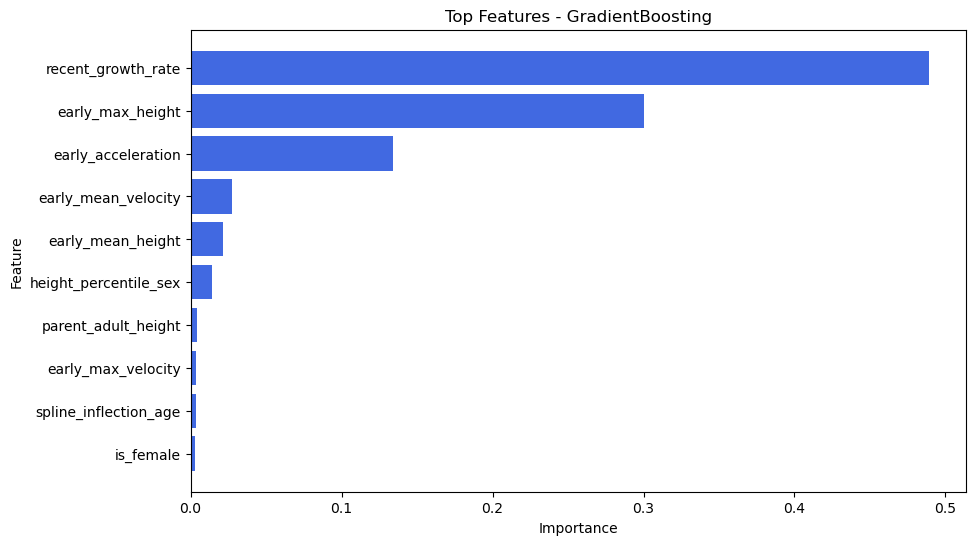

Training model for age 14...
Optimized weights: Lasso=0.306, RF=0.694, GB=0.000
Optimized weights: Lasso=0.025, RF=0.615, GB=0.359
Optimized weights: Lasso=0.952, RF=0.048, GB=0.000
Optimized weights: Lasso=0.538, RF=0.462, GB=0.000
Optimized weights: Lasso=0.521, RF=0.324, GB=0.155
Cross-Validation Mean RMSE: 5.8774
Tuning Lasso hyperparameters...
Best Lasso alpha: 0.15414380434799493
Tuning RandomForest hyperparameters...
Best RF params: {'model__max_depth': 12, 'model__min_samples_split': 2, 'model__n_estimators': 150}
Tuning GradientBoostingRegressor hyperparameters...
Best GB params: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validati

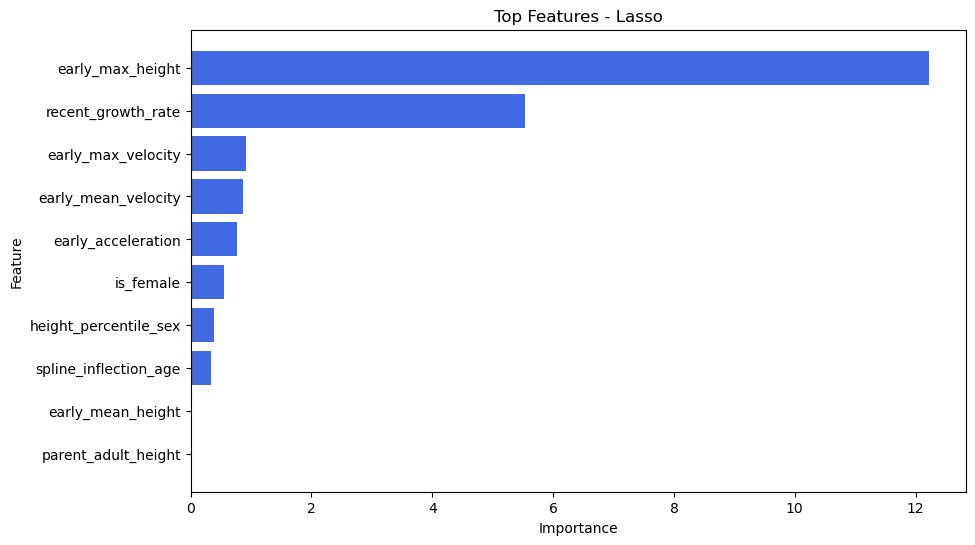

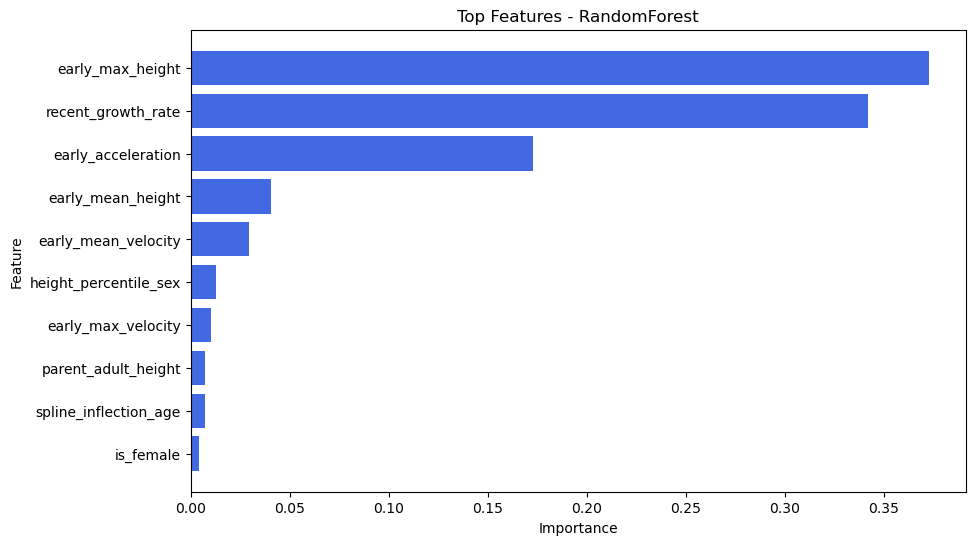

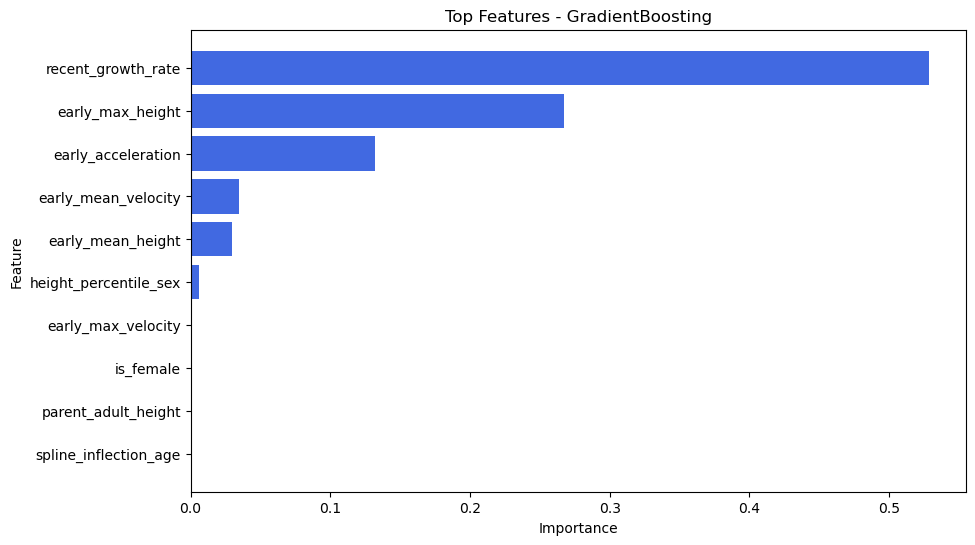

Training model for age 15...
Optimized weights: Lasso=0.460, RF=0.540, GB=0.000
Optimized weights: Lasso=0.000, RF=0.286, GB=0.714
Optimized weights: Lasso=0.829, RF=0.070, GB=0.101
Optimized weights: Lasso=0.584, RF=0.359, GB=0.056
Optimized weights: Lasso=0.476, RF=0.524, GB=0.000
Cross-Validation Mean RMSE: 6.5558
Tuning Lasso hyperparameters...
Best Lasso alpha: 0.1051781010444786
Tuning RandomForest hyperparameters...
Best RF params: {'model__max_depth': 12, 'model__min_samples_split': 2, 'model__n_estimators': 150}
Tuning GradientBoostingRegressor hyperparameters...
Best GB params: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validati

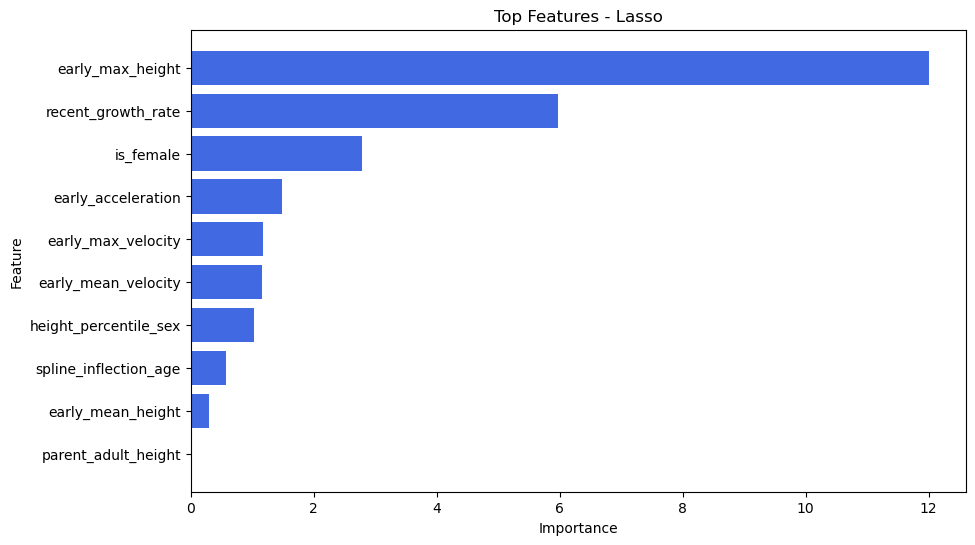

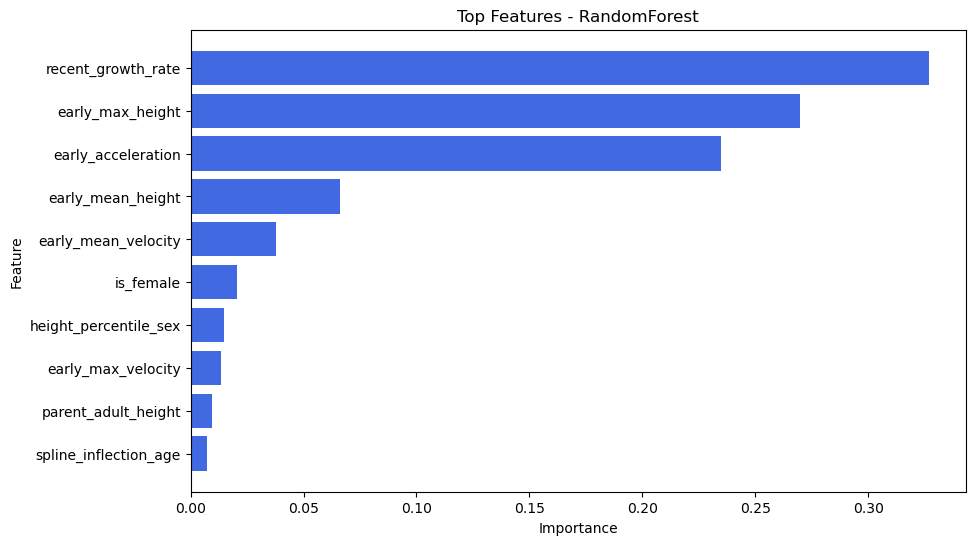

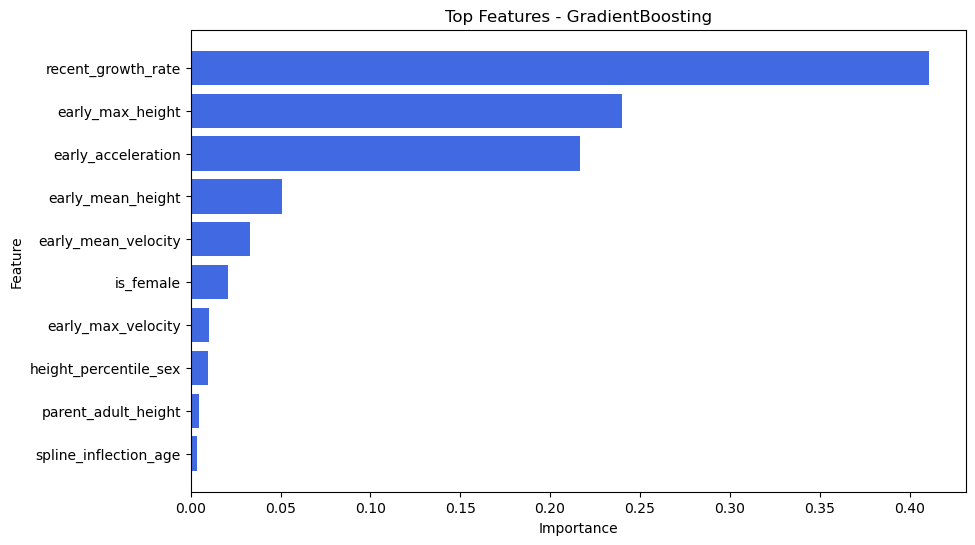

Training model for age 16...
Optimized weights: Lasso=0.316, RF=0.684, GB=0.000
Optimized weights: Lasso=0.043, RF=0.401, GB=0.556
Optimized weights: Lasso=0.829, RF=0.171, GB=0.000
Optimized weights: Lasso=0.473, RF=0.368, GB=0.159
Optimized weights: Lasso=0.477, RF=0.523, GB=0.000
Cross-Validation Mean RMSE: 7.0698
Tuning Lasso hyperparameters...
Best Lasso alpha: 0.14135498587216058
Tuning RandomForest hyperparameters...
Best RF params: {'model__max_depth': 15, 'model__min_samples_split': 2, 'model__n_estimators': 150}
Tuning GradientBoostingRegressor hyperparameters...
Best GB params: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validat

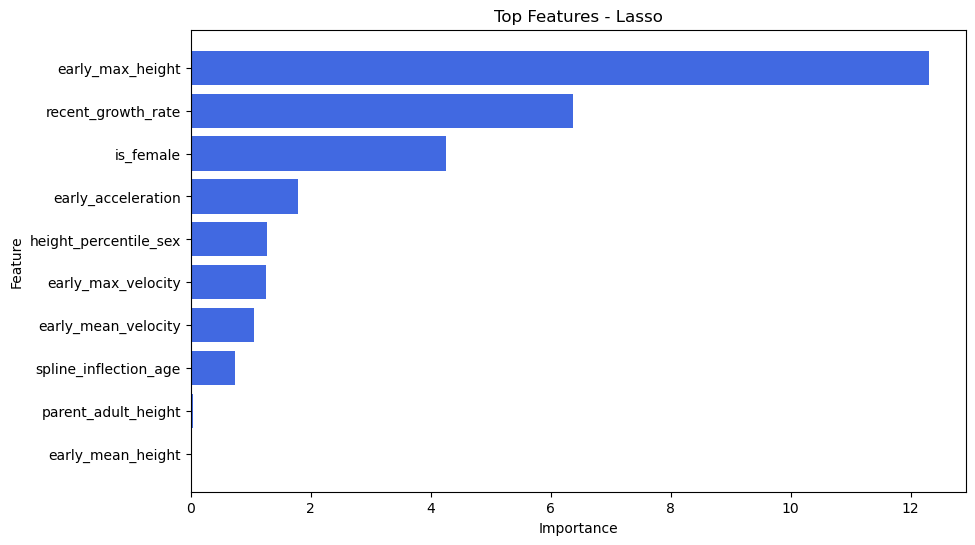

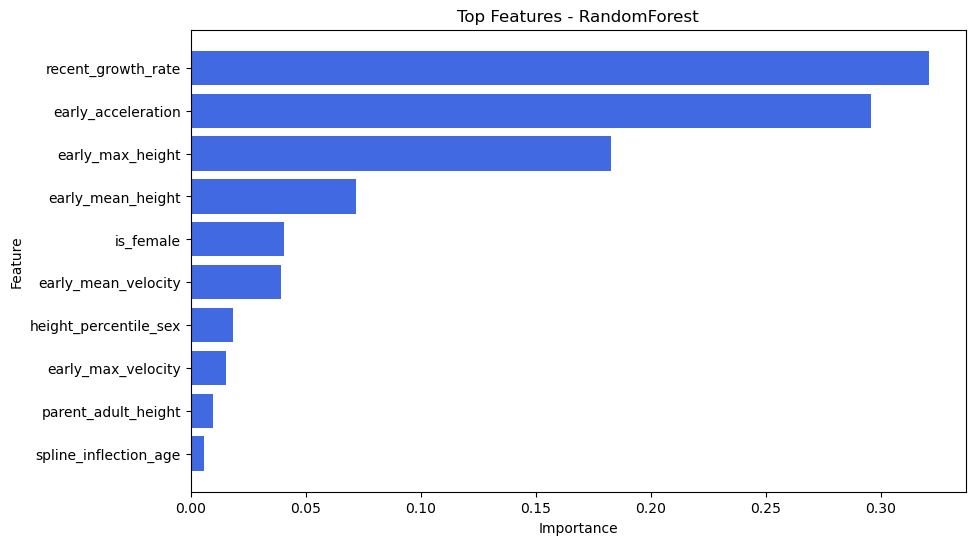

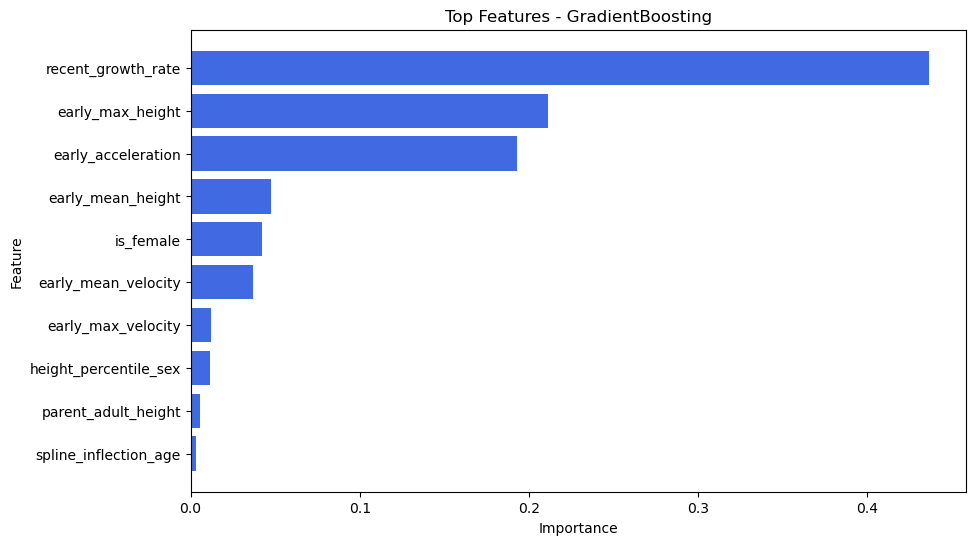

Training model for age 18...
Optimized weights: Lasso=0.278, RF=0.602, GB=0.120
Optimized weights: Lasso=0.050, RF=0.950, GB=0.000
Optimized weights: Lasso=0.863, RF=0.054, GB=0.083
Optimized weights: Lasso=0.265, RF=0.000, GB=0.735
Optimized weights: Lasso=0.423, RF=0.577, GB=0.000
Cross-Validation Mean RMSE: 7.5711
Tuning Lasso hyperparameters...
Best Lasso alpha: 0.12314854970425723
Tuning RandomForest hyperparameters...
Best RF params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 150}
Tuning GradientBoostingRegressor hyperparameters...
Best GB params: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validat

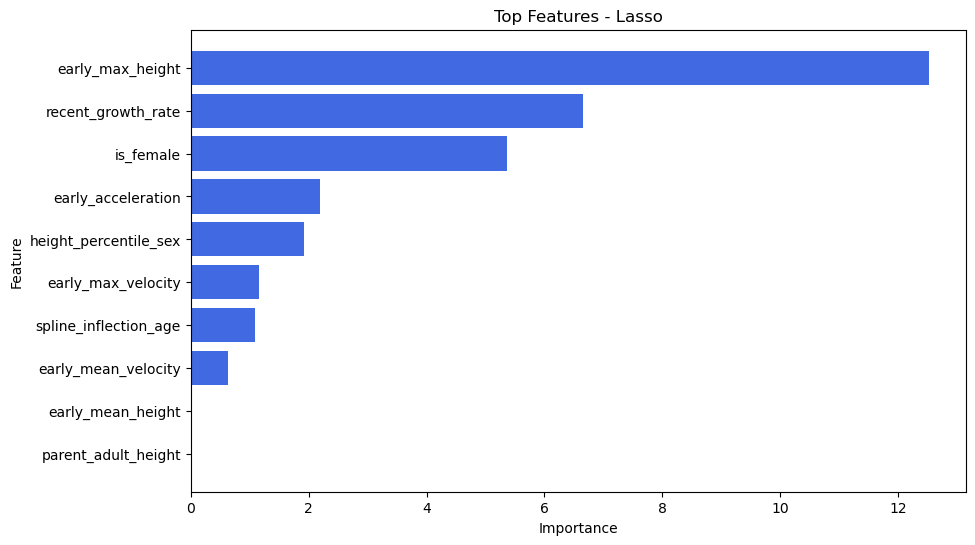

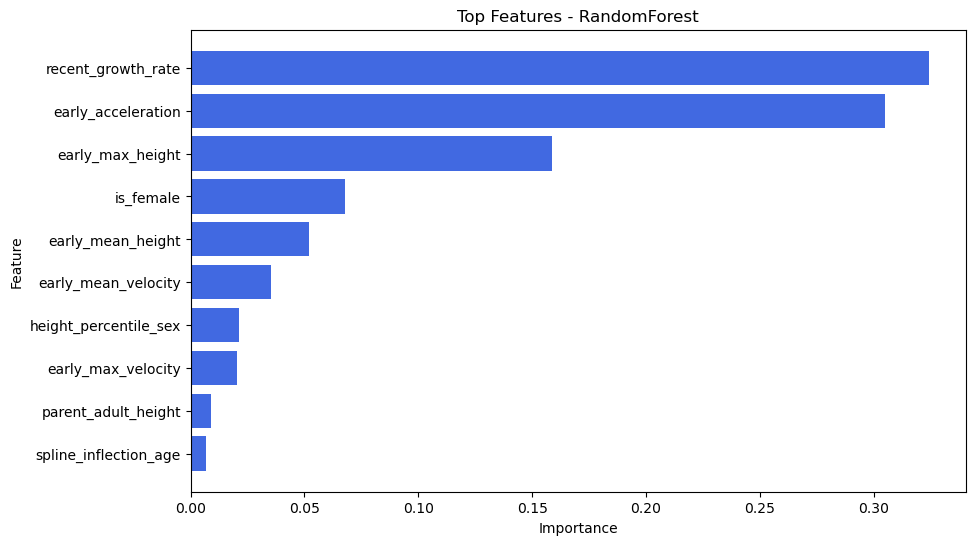

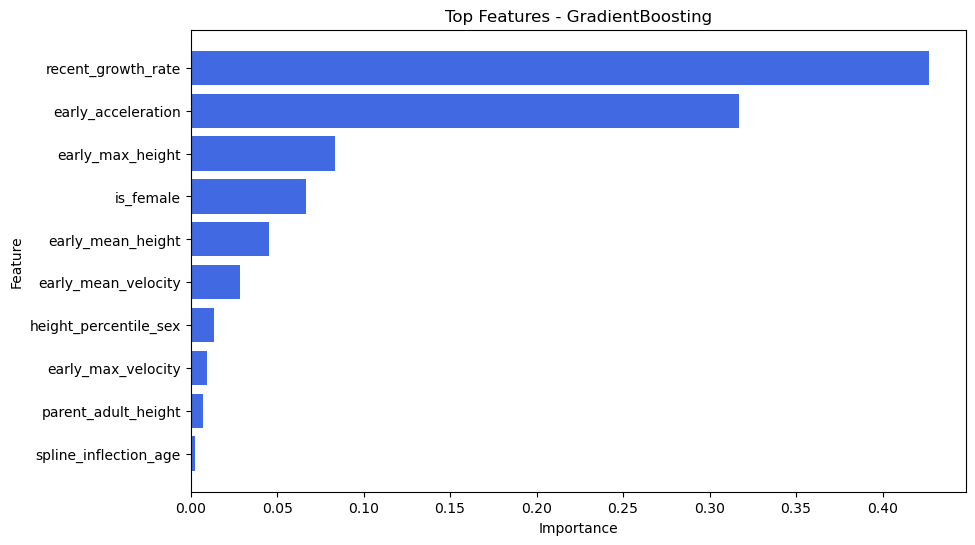

Making predictions for the test set...
Done! Submission file created.


In [44]:
ensemble_results = {}
for age in target_ages:
    print(f"Training model for age {age}...")
    X_train, y_train = prepare_modeling_data_v3(gen2_train, age)

    ensemble = WeightedEnsembleGB()

    cv_rmse = ensemble.cross_validate_ensemble(X_train, y_train, cv_folds=5)
    
    ensemble.fit(X_train, y_train, tune=True)
    ensemble_results[age] = ensemble
    feature_names = X_train.columns
    plot_feature_importance(ensemble.lasso_pipeline, feature_names, model_name="Lasso")
    plot_feature_importance(ensemble.rf_pipeline, feature_names, model_name="RandomForest")
    plot_feature_importance(ensemble.gb_pipeline, feature_names, model_name="GradientBoosting")

print("Making predictions for the test set...")
submission = sample_sub.copy()
submission["SHgt_cm"] = np.nan

for gen2_id, group in gen2_test.groupby("gen2_id"):
    X_test, _ = prepare_modeling_data_v3(group, target_age=10, is_test_set=True)
    
    if X_test.empty:
        continue
    
    for age in target_ages:
        gen2id_age = f"{gen2_id}_{age}"
        if gen2id_age in submission["gen2id_age"].values:
            pred = ensemble_results[age].predict(X_test)
            submission.loc[submission["gen2id_age"] == gen2id_age, "SHgt_cm"] = pred[0]

if submission["SHgt_cm"].isna().any():
    mean_height = gen2_train['SHgt_cm'].mean()  # mean height as fallback
    submission['SHgt_cm'].fillna(mean_height, inplace=True)
    print(f"Filled {submission['SHgt_cm'].isna().sum()} missing predictions with mean height.")


submission.to_csv("../models/submissions/lasso_rf_gb_submission.csv", index=False)
print("Done! Submission file created.")

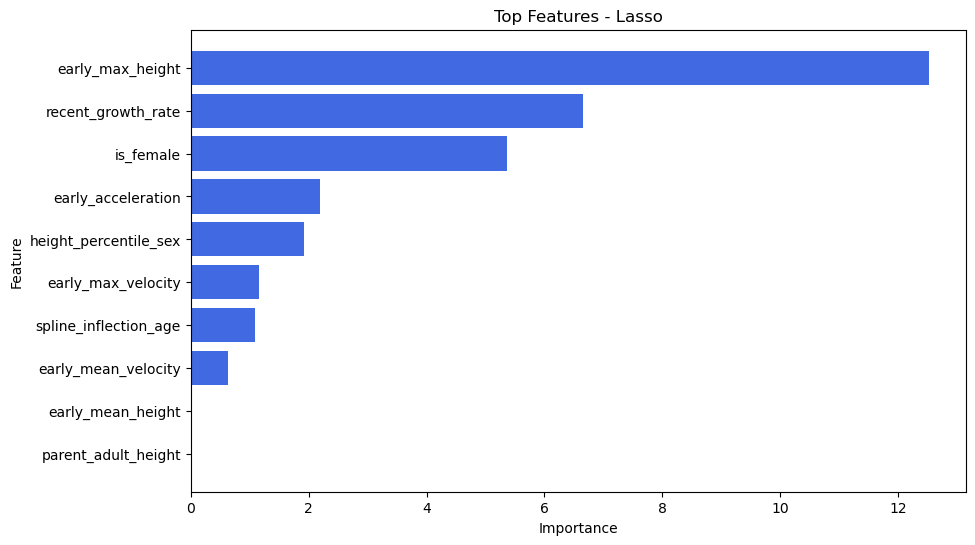

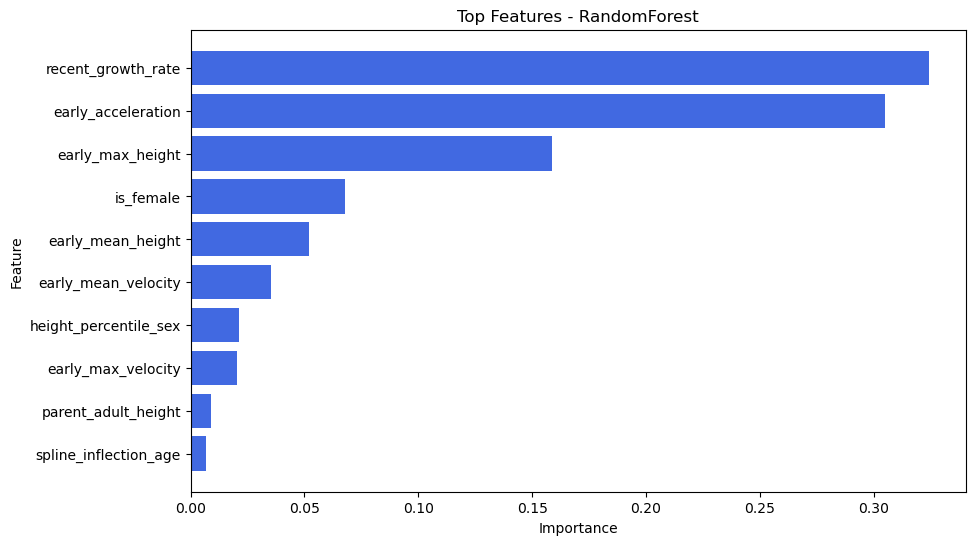

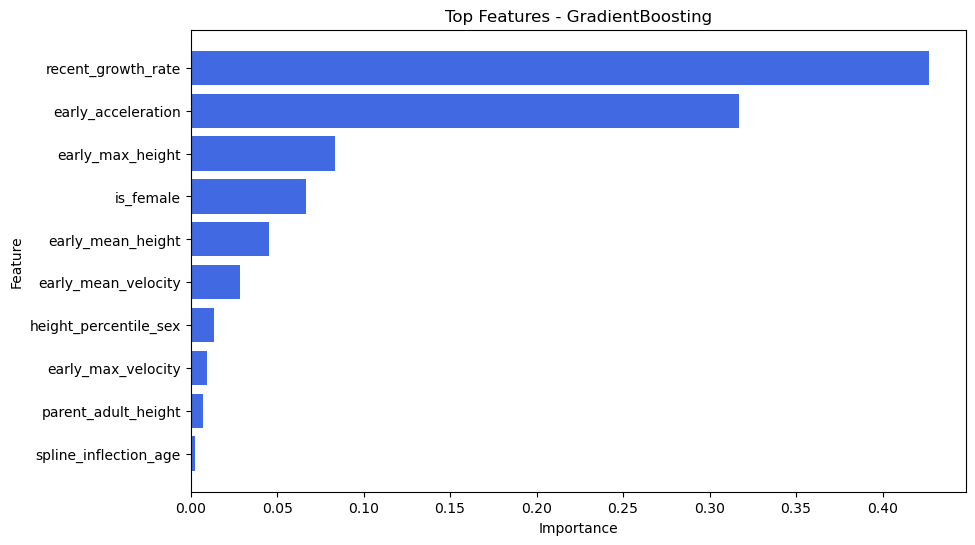

In [45]:
feature_names = X_train.columns
plot_feature_importance(ensemble.lasso_pipeline, feature_names, model_name="Lasso")
plot_feature_importance(ensemble.rf_pipeline, feature_names, model_name="RandomForest")
plot_feature_importance(ensemble.gb_pipeline, feature_names, model_name="GradientBoosting")